In [ ]:
# Install Dependencies
!pip install torch torchvision matplotlib tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 29.6 MB/s eta 0:00:00


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
# Dataset Loader
class CTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_names = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.file_names[idx])
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image

In [4]:
# Diffusion Noise Scheduler (Cosine)
class DiffusionScheduler:
    def __init__(self, timesteps=1000):
        self.timesteps = timesteps
        self.betas = self.cosine_beta_schedule(timesteps)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = np.cumprod(self.alphas)
        self.alphas_cumprod = torch.tensor(self.alphas_cumprod, dtype=torch.float32)
        self.betas = torch.tensor(self.betas, dtype=torch.float32)
        self.alphas = torch.tensor(self.alphas, dtype=torch.float32)

    def cosine_beta_schedule(self, timesteps, s=0.008):
        steps = timesteps + 1
        x = np.linspace(0, timesteps, steps)
        alphas_cumprod = np.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return np.clip(betas, 0.0001, 0.02)

    def noise_image(self, x_start, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x_start)
        sqrt_alpha_cumprod = self.alphas_cumprod[t.cpu()].sqrt().unsqueeze(1).unsqueeze(2).unsqueeze(3).to(x_start.device)
        sqrt_one_minus_alpha = (1.0 - self.alphas_cumprod[t.cpu()]).sqrt().unsqueeze(1).unsqueeze(2).unsqueeze(3).to(x_start.device)
        return sqrt_alpha_cumprod * x_start + sqrt_one_minus_alpha * noise, noise

    # Reverse diffusion sampling function
    def sample(self, model, image_size=(1, 128, 128), device='cuda'):
        model.eval()
        with torch.no_grad():
            x = torch.randn(1, *image_size).to(device)
            for t in reversed(range(self.timesteps)):
                t_tensor = torch.full((1,), t, device=device, dtype=torch.long)
                alpha = self.alphas[t].to(device)
                alpha_cumprod = self.alphas_cumprod[t].to(device)
                beta = self.betas[t].to(device)
                sqrt_recip_alpha = torch.sqrt(1.0 / alpha)
                sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - alpha_cumprod)

                pred_noise = model(x)
                x0_pred = (x - sqrt_one_minus_alpha_cumprod * pred_noise) / torch.sqrt(alpha_cumprod)

                if t > 0:
                    noise = torch.randn_like(x)
                    posterior_mean = sqrt_recip_alpha * (x - beta / sqrt_one_minus_alpha_cumprod * pred_noise)
                    x = posterior_mean + torch.sqrt(beta) * noise
                else:
                    x = sqrt_recip_alpha * (x - beta / sqrt_one_minus_alpha_cumprod * pred_noise)
            return x


# Generator (Improved UNet)
class ImprovedUNet(nn.Module):
    def __init__(self):
        super(ImprovedUNet, self).__init__()
        self.down1 = nn.Sequential(nn.Conv2d(1, 64, 4, 2, 1), nn.ReLU())
        self.down2 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU())
        self.middle = nn.Sequential(nn.Conv2d(128, 128, 3, 1, 1), nn.ReLU())
        self.up1 = nn.Sequential(nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU())
        self.up2 = nn.Sequential(nn.ConvTranspose2d(64, 1, 4, 2, 1), nn.Tanh())
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        m = self.middle(d2)
        u1 = self.up1(m)
        u2 = self.up2(u1)
        return u2


# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128*32*32, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

In [5]:
# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
train_dir = '/content/drive/MyDrive/CHAOS_Processed/Train'
checkpoint_dir = '/content/drive/MyDrive/CHAOS_Processed/Check_Points'
os.makedirs(checkpoint_dir, exist_ok=True)

# Transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Dataset & DataLoader
train_dataset = CTDataset(root_dir=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize models
generator = ImprovedUNet().to(device)
discriminator = Discriminator().to(device)
diffusion = DiffusionScheduler(timesteps=1000)

# Optimizers & Losses
opt_gen = optim.Adam(generator.parameters(), lr=1e-4)
opt_disc = optim.Adam(discriminator.parameters(), lr=1e-4)
mse = nn.MSELoss()
bce = nn.BCELoss()


In [ ]:
start_epoch = 0
checkpoint_path = f'{checkpoint_dir}/model_epoch_50.pth'  # Change this to match your last saved epoch

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    opt_gen.load_state_dict(checkpoint['opt_gen_state_dict'])
    opt_disc.load_state_dict(checkpoint['opt_disc_state_dict'])
    gen_losses = checkpoint['gen_losses']
    disc_losses = checkpoint['disc_losses']
    start_epoch = checkpoint['epoch']
    print(f"Resuming training from epoch {start_epoch}")

In [6]:
# Training Loop
epochs = 300
gen_losses = []
disc_losses = []

for epoch in range(epochs):
    gen_loss_total = 0
    disc_loss_total = 0
    for images in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        images = images.to(device)

        t = torch.randint(0, diffusion.timesteps, (images.size(0),)).long().to(device)
        noise = torch.randn_like(images).to(device)
        noisy_images, noise_target = diffusion.noise_image(images, t, noise)

        # Discriminator update
        gen_noise_pred = generator(noisy_images)
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        disc_real = discriminator(images)
        disc_fake = discriminator(gen_noise_pred.detach())

        loss_disc_real = bce(disc_real, real_labels)
        loss_disc_fake = bce(disc_fake, fake_labels)
        loss_disc = (loss_disc_real + loss_disc_fake) / 2

        opt_disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        # Generator update
        disc_fake = discriminator(gen_noise_pred)
        loss_gen_adv = bce(disc_fake, real_labels)
        loss_gen_diff = mse(gen_noise_pred, noise_target)
        loss_gen = loss_gen_adv + loss_gen_diff

        opt_gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        gen_loss_total += loss_gen.item()
        disc_loss_total += loss_disc.item()

    avg_gen_loss = gen_loss_total / len(train_loader)
    avg_disc_loss = disc_loss_total / len(train_loader)
    gen_losses.append(avg_gen_loss)
    disc_losses.append(avg_disc_loss)
    print(f"Epoch [{epoch+1}/{epochs}]  Loss D: {avg_disc_loss:.4f}  Loss G: {avg_gen_loss:.4f}")

    # Save every 20 epochs
    if (epoch + 1) % 20 == 0 or (epoch + 1) == epochs:
        torch.save({
            'epoch': epoch + 1,
            'generator_state_dict': generator.state_dict(),
            'discriminator_state_dict': discriminator.state_dict(),
            'opt_gen_state_dict': opt_gen.state_dict(),
            'opt_disc_state_dict': opt_disc.state_dict(),
            'gen_losses': gen_losses,
            'disc_losses': disc_losses
        }, f'{checkpoint_dir}/model_epoch_{epoch+1}.pth')

print("Training completed!")

Epoch 1/300: 100%|██████████| 101/101 [01:26<00:00,  1.16it/s]


Epoch [1/300]  Loss D: 0.2876  Loss G: 5.4665


Epoch 2/300: 100%|██████████| 101/101 [00:25<00:00,  4.02it/s]


Epoch [2/300]  Loss D: 0.2457  Loss G: 5.1939


Epoch 3/300: 100%|██████████| 101/101 [00:25<00:00,  3.97it/s]


Epoch [3/300]  Loss D: 0.1819  Loss G: 4.4948


Epoch 4/300: 100%|██████████| 101/101 [00:25<00:00,  4.03it/s]


Epoch [4/300]  Loss D: 0.3168  Loss G: 4.3745


Epoch 5/300: 100%|██████████| 101/101 [00:25<00:00,  4.03it/s]


Epoch [5/300]  Loss D: 0.4201  Loss G: 3.6909


Epoch 6/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [6/300]  Loss D: 0.3802  Loss G: 3.4552


Epoch 7/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [7/300]  Loss D: 0.4204  Loss G: 3.3887


Epoch 8/300: 100%|██████████| 101/101 [00:25<00:00,  4.03it/s]


Epoch [8/300]  Loss D: 0.4315  Loss G: 3.2742


Epoch 9/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [9/300]  Loss D: 0.4510  Loss G: 3.3502


Epoch 10/300: 100%|██████████| 101/101 [00:25<00:00,  4.02it/s]


Epoch [10/300]  Loss D: 0.3943  Loss G: 3.4671


Epoch 11/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [11/300]  Loss D: 0.4229  Loss G: 3.2350


Epoch 12/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [12/300]  Loss D: 0.4056  Loss G: 3.3073


Epoch 13/300: 100%|██████████| 101/101 [00:24<00:00,  4.13it/s]


Epoch [13/300]  Loss D: 0.4097  Loss G: 3.3544


Epoch 14/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [14/300]  Loss D: 0.3832  Loss G: 3.3205


Epoch 15/300: 100%|██████████| 101/101 [00:25<00:00,  4.04it/s]


Epoch [15/300]  Loss D: 0.3706  Loss G: 3.3024


Epoch 16/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [16/300]  Loss D: 0.3777  Loss G: 3.3977


Epoch 17/300: 100%|██████████| 101/101 [00:24<00:00,  4.04it/s]


Epoch [17/300]  Loss D: 0.3672  Loss G: 3.3942


Epoch 18/300: 100%|██████████| 101/101 [00:25<00:00,  4.00it/s]


Epoch [18/300]  Loss D: 0.3567  Loss G: 3.4654


Epoch 19/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [19/300]  Loss D: 0.3115  Loss G: 3.5716


Epoch 20/300: 100%|██████████| 101/101 [00:24<00:00,  4.12it/s]


Epoch [20/300]  Loss D: 0.3428  Loss G: 3.5468


Epoch 21/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [21/300]  Loss D: 0.3335  Loss G: 3.4895


Epoch 22/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [22/300]  Loss D: 0.3422  Loss G: 3.5246


Epoch 23/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [23/300]  Loss D: 0.3369  Loss G: 3.4790


Epoch 24/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [24/300]  Loss D: 0.3456  Loss G: 3.5809


Epoch 25/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [25/300]  Loss D: 0.3385  Loss G: 3.5408


Epoch 26/300: 100%|██████████| 101/101 [00:24<00:00,  4.16it/s]


Epoch [26/300]  Loss D: 0.3478  Loss G: 3.5850


Epoch 27/300: 100%|██████████| 101/101 [00:24<00:00,  4.12it/s]


Epoch [27/300]  Loss D: 0.3445  Loss G: 3.5543


Epoch 28/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [28/300]  Loss D: 0.3554  Loss G: 3.5981


Epoch 29/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [29/300]  Loss D: 0.3328  Loss G: 3.6341


Epoch 30/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [30/300]  Loss D: 0.3329  Loss G: 3.6810


Epoch 31/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [31/300]  Loss D: 0.3297  Loss G: 3.6662


Epoch 32/300: 100%|██████████| 101/101 [00:24<00:00,  4.12it/s]


Epoch [32/300]  Loss D: 0.3306  Loss G: 3.7473


Epoch 33/300: 100%|██████████| 101/101 [00:24<00:00,  4.12it/s]


Epoch [33/300]  Loss D: 0.3452  Loss G: 3.6334


Epoch 34/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [34/300]  Loss D: 0.3415  Loss G: 3.6471


Epoch 35/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [35/300]  Loss D: 0.3340  Loss G: 3.7295


Epoch 36/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [36/300]  Loss D: 0.3319  Loss G: 3.7218


Epoch 37/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [37/300]  Loss D: 0.3308  Loss G: 3.6755


Epoch 38/300: 100%|██████████| 101/101 [00:24<00:00,  4.12it/s]


Epoch [38/300]  Loss D: 0.3373  Loss G: 3.7186


Epoch 39/300: 100%|██████████| 101/101 [00:24<00:00,  4.14it/s]


Epoch [39/300]  Loss D: 0.3346  Loss G: 3.6766


Epoch 40/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [40/300]  Loss D: 0.3300  Loss G: 3.7152


Epoch 41/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [41/300]  Loss D: 0.3303  Loss G: 3.6805


Epoch 42/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [42/300]  Loss D: 0.3459  Loss G: 3.7865


Epoch 43/300: 100%|██████████| 101/101 [00:24<00:00,  4.12it/s]


Epoch [43/300]  Loss D: 0.3222  Loss G: 3.7227


Epoch 44/300: 100%|██████████| 101/101 [00:24<00:00,  4.12it/s]


Epoch [44/300]  Loss D: 0.3368  Loss G: 3.7370


Epoch 45/300: 100%|██████████| 101/101 [00:24<00:00,  4.14it/s]


Epoch [45/300]  Loss D: 0.3274  Loss G: 3.6792


Epoch 46/300: 100%|██████████| 101/101 [00:24<00:00,  4.10it/s]


Epoch [46/300]  Loss D: 0.3208  Loss G: 3.6461


Epoch 47/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [47/300]  Loss D: 0.3289  Loss G: 3.6856


Epoch 48/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [48/300]  Loss D: 0.3216  Loss G: 3.6793


Epoch 49/300: 100%|██████████| 101/101 [00:24<00:00,  4.10it/s]


Epoch [49/300]  Loss D: 0.3194  Loss G: 3.6619


Epoch 50/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [50/300]  Loss D: 0.3153  Loss G: 3.6948


Epoch 51/300: 100%|██████████| 101/101 [00:24<00:00,  4.18it/s]


Epoch [51/300]  Loss D: 0.3102  Loss G: 3.7685


Epoch 52/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [52/300]  Loss D: 0.3036  Loss G: 3.7362


Epoch 53/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [53/300]  Loss D: 0.3024  Loss G: 3.7864


Epoch 54/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [54/300]  Loss D: 0.3125  Loss G: 3.7474


Epoch 55/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [55/300]  Loss D: 0.3130  Loss G: 3.6957


Epoch 56/300: 100%|██████████| 101/101 [00:24<00:00,  4.14it/s]


Epoch [56/300]  Loss D: 0.3055  Loss G: 3.7665


Epoch 57/300: 100%|██████████| 101/101 [00:24<00:00,  4.17it/s]


Epoch [57/300]  Loss D: 0.3014  Loss G: 3.7319


Epoch 58/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [58/300]  Loss D: 0.3052  Loss G: 3.7434


Epoch 59/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [59/300]  Loss D: 0.3064  Loss G: 3.7671


Epoch 60/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [60/300]  Loss D: 0.2983  Loss G: 3.7920


Epoch 61/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [61/300]  Loss D: 0.3012  Loss G: 3.7680


Epoch 62/300: 100%|██████████| 101/101 [00:25<00:00,  4.03it/s]


Epoch [62/300]  Loss D: 0.3117  Loss G: 3.8289


Epoch 63/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [63/300]  Loss D: 0.2973  Loss G: 3.7842


Epoch 64/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [64/300]  Loss D: 0.3028  Loss G: 3.8285


Epoch 65/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [65/300]  Loss D: 0.2844  Loss G: 3.7975


Epoch 66/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [66/300]  Loss D: 0.2874  Loss G: 3.8119


Epoch 67/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [67/300]  Loss D: 0.2919  Loss G: 3.8006


Epoch 68/300: 100%|██████████| 101/101 [00:24<00:00,  4.10it/s]


Epoch [68/300]  Loss D: 0.2983  Loss G: 3.8115


Epoch 69/300: 100%|██████████| 101/101 [00:24<00:00,  4.17it/s]


Epoch [69/300]  Loss D: 0.2946  Loss G: 3.8918


Epoch 70/300: 100%|██████████| 101/101 [00:24<00:00,  4.12it/s]


Epoch [70/300]  Loss D: 0.2842  Loss G: 3.8292


Epoch 71/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [71/300]  Loss D: 0.2853  Loss G: 3.8892


Epoch 72/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [72/300]  Loss D: 0.2839  Loss G: 3.8480


Epoch 73/300: 100%|██████████| 101/101 [00:25<00:00,  4.04it/s]


Epoch [73/300]  Loss D: 0.2866  Loss G: 3.8471


Epoch 74/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [74/300]  Loss D: 0.2817  Loss G: 3.8489


Epoch 75/300: 100%|██████████| 101/101 [00:24<00:00,  4.16it/s]


Epoch [75/300]  Loss D: 0.2807  Loss G: 3.8958


Epoch 76/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [76/300]  Loss D: 0.2722  Loss G: 3.8562


Epoch 77/300: 100%|██████████| 101/101 [00:25<00:00,  4.02it/s]


Epoch [77/300]  Loss D: 0.2746  Loss G: 3.8788


Epoch 78/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [78/300]  Loss D: 0.2719  Loss G: 3.8836


Epoch 79/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [79/300]  Loss D: 0.2674  Loss G: 3.9359


Epoch 80/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [80/300]  Loss D: 0.2655  Loss G: 3.9338


Epoch 81/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [81/300]  Loss D: 0.2580  Loss G: 3.9562


Epoch 82/300: 100%|██████████| 101/101 [00:24<00:00,  4.15it/s]


Epoch [82/300]  Loss D: 0.2706  Loss G: 3.9145


Epoch 83/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [83/300]  Loss D: 0.2597  Loss G: 3.9409


Epoch 84/300: 100%|██████████| 101/101 [00:24<00:00,  4.12it/s]


Epoch [84/300]  Loss D: 0.2709  Loss G: 3.9904


Epoch 85/300: 100%|██████████| 101/101 [00:24<00:00,  4.13it/s]


Epoch [85/300]  Loss D: 0.2762  Loss G: 3.9426


Epoch 86/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [86/300]  Loss D: 0.2621  Loss G: 3.9861


Epoch 87/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [87/300]  Loss D: 0.2607  Loss G: 3.9972


Epoch 88/300: 100%|██████████| 101/101 [00:24<00:00,  4.16it/s]


Epoch [88/300]  Loss D: 0.2516  Loss G: 4.0018


Epoch 89/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [89/300]  Loss D: 0.2509  Loss G: 4.0210


Epoch 90/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [90/300]  Loss D: 0.2518  Loss G: 3.9966


Epoch 91/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [91/300]  Loss D: 0.2479  Loss G: 4.0989


Epoch 92/300: 100%|██████████| 101/101 [00:24<00:00,  4.14it/s]


Epoch [92/300]  Loss D: 0.2473  Loss G: 4.0650


Epoch 93/300: 100%|██████████| 101/101 [00:24<00:00,  4.10it/s]


Epoch [93/300]  Loss D: 0.2517  Loss G: 4.0559


Epoch 94/300: 100%|██████████| 101/101 [00:23<00:00,  4.24it/s]


Epoch [94/300]  Loss D: 0.2479  Loss G: 4.1042


Epoch 95/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [95/300]  Loss D: 0.2418  Loss G: 4.0802


Epoch 96/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [96/300]  Loss D: 0.2387  Loss G: 4.1455


Epoch 97/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [97/300]  Loss D: 0.2379  Loss G: 4.1065


Epoch 98/300: 100%|██████████| 101/101 [00:24<00:00,  4.10it/s]


Epoch [98/300]  Loss D: 0.2358  Loss G: 4.1400


Epoch 99/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [99/300]  Loss D: 0.2367  Loss G: 4.1429


Epoch 100/300: 100%|██████████| 101/101 [00:24<00:00,  4.20it/s]


Epoch [100/300]  Loss D: 0.2413  Loss G: 4.1369


Epoch 101/300: 100%|██████████| 101/101 [00:24<00:00,  4.10it/s]


Epoch [101/300]  Loss D: 0.2358  Loss G: 4.1390


Epoch 102/300: 100%|██████████| 101/101 [00:24<00:00,  4.10it/s]


Epoch [102/300]  Loss D: 0.2275  Loss G: 4.1774


Epoch 103/300: 100%|██████████| 101/101 [00:24<00:00,  4.13it/s]


Epoch [103/300]  Loss D: 0.2392  Loss G: 4.0847


Epoch 104/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [104/300]  Loss D: 0.2295  Loss G: 4.1115


Epoch 105/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [105/300]  Loss D: 0.2392  Loss G: 4.1331


Epoch 106/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [106/300]  Loss D: 0.2298  Loss G: 4.1740


Epoch 107/300: 100%|██████████| 101/101 [00:24<00:00,  4.13it/s]


Epoch [107/300]  Loss D: 0.2201  Loss G: 4.2142


Epoch 108/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [108/300]  Loss D: 0.2245  Loss G: 4.1740


Epoch 109/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [109/300]  Loss D: 0.2228  Loss G: 4.2142


Epoch 110/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [110/300]  Loss D: 0.2176  Loss G: 4.2308


Epoch 111/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [111/300]  Loss D: 0.2073  Loss G: 4.2650


Epoch 112/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [112/300]  Loss D: 0.2130  Loss G: 4.2704


Epoch 113/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [113/300]  Loss D: 0.2121  Loss G: 4.3238


Epoch 114/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [114/300]  Loss D: 0.2216  Loss G: 4.2839


Epoch 115/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [115/300]  Loss D: 0.2056  Loss G: 4.2857


Epoch 116/300: 100%|██████████| 101/101 [00:24<00:00,  4.10it/s]


Epoch [116/300]  Loss D: 0.2156  Loss G: 4.2923


Epoch 117/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [117/300]  Loss D: 0.2117  Loss G: 4.3327


Epoch 118/300: 100%|██████████| 101/101 [00:24<00:00,  4.13it/s]


Epoch [118/300]  Loss D: 0.2059  Loss G: 4.3721


Epoch 119/300: 100%|██████████| 101/101 [00:24<00:00,  4.14it/s]


Epoch [119/300]  Loss D: 0.1943  Loss G: 4.3894


Epoch 120/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [120/300]  Loss D: 0.2063  Loss G: 4.3466


Epoch 121/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [121/300]  Loss D: 0.2008  Loss G: 4.4145


Epoch 122/300: 100%|██████████| 101/101 [00:24<00:00,  4.10it/s]


Epoch [122/300]  Loss D: 0.2053  Loss G: 4.4008


Epoch 123/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [123/300]  Loss D: 0.1999  Loss G: 4.4151


Epoch 124/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [124/300]  Loss D: 0.1994  Loss G: 4.4293


Epoch 125/300: 100%|██████████| 101/101 [00:24<00:00,  4.12it/s]


Epoch [125/300]  Loss D: 0.2001  Loss G: 4.4050


Epoch 126/300: 100%|██████████| 101/101 [00:24<00:00,  4.12it/s]


Epoch [126/300]  Loss D: 0.1902  Loss G: 4.4893


Epoch 127/300: 100%|██████████| 101/101 [00:24<00:00,  4.12it/s]


Epoch [127/300]  Loss D: 0.1910  Loss G: 4.4804


Epoch 128/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [128/300]  Loss D: 0.1922  Loss G: 4.4406


Epoch 129/300: 100%|██████████| 101/101 [00:25<00:00,  3.97it/s]


Epoch [129/300]  Loss D: 0.1937  Loss G: 4.5128


Epoch 130/300: 100%|██████████| 101/101 [00:25<00:00,  4.00it/s]


Epoch [130/300]  Loss D: 0.1913  Loss G: 4.5081


Epoch 131/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [131/300]  Loss D: 0.1903  Loss G: 4.5149


Epoch 132/300: 100%|██████████| 101/101 [00:25<00:00,  4.03it/s]


Epoch [132/300]  Loss D: 0.1907  Loss G: 4.5294


Epoch 133/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [133/300]  Loss D: 0.1926  Loss G: 4.5182


Epoch 134/300: 100%|██████████| 101/101 [00:25<00:00,  4.03it/s]


Epoch [134/300]  Loss D: 0.1883  Loss G: 4.5796


Epoch 135/300: 100%|██████████| 101/101 [00:24<00:00,  4.04it/s]


Epoch [135/300]  Loss D: 0.1904  Loss G: 4.5568


Epoch 136/300: 100%|██████████| 101/101 [00:25<00:00,  4.02it/s]


Epoch [136/300]  Loss D: 0.1779  Loss G: 4.5561


Epoch 137/300: 100%|██████████| 101/101 [00:24<00:00,  4.10it/s]


Epoch [137/300]  Loss D: 0.1842  Loss G: 4.5351


Epoch 138/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [138/300]  Loss D: 0.1897  Loss G: 4.5453


Epoch 139/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [139/300]  Loss D: 0.1809  Loss G: 4.5773


Epoch 140/300: 100%|██████████| 101/101 [00:24<00:00,  4.10it/s]


Epoch [140/300]  Loss D: 0.1884  Loss G: 4.5718


Epoch 141/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [141/300]  Loss D: 0.1800  Loss G: 4.5912


Epoch 142/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [142/300]  Loss D: 0.1781  Loss G: 4.6813


Epoch 143/300: 100%|██████████| 101/101 [00:25<00:00,  3.99it/s]


Epoch [143/300]  Loss D: 0.1828  Loss G: 4.6487


Epoch 144/300: 100%|██████████| 101/101 [00:25<00:00,  3.97it/s]


Epoch [144/300]  Loss D: 0.1857  Loss G: 4.6446


Epoch 145/300: 100%|██████████| 101/101 [00:25<00:00,  4.03it/s]


Epoch [145/300]  Loss D: 0.1682  Loss G: 4.7108


Epoch 146/300: 100%|██████████| 101/101 [00:25<00:00,  3.98it/s]


Epoch [146/300]  Loss D: 0.1782  Loss G: 4.7227


Epoch 147/300: 100%|██████████| 101/101 [00:25<00:00,  3.98it/s]


Epoch [147/300]  Loss D: 0.1658  Loss G: 4.6601


Epoch 148/300: 100%|██████████| 101/101 [00:25<00:00,  3.98it/s]


Epoch [148/300]  Loss D: 0.1801  Loss G: 4.7028


Epoch 149/300: 100%|██████████| 101/101 [00:25<00:00,  4.01it/s]


Epoch [149/300]  Loss D: 0.1687  Loss G: 4.7582


Epoch 150/300: 100%|██████████| 101/101 [00:25<00:00,  4.01it/s]


Epoch [150/300]  Loss D: 0.1790  Loss G: 4.8069


Epoch 151/300: 100%|██████████| 101/101 [00:25<00:00,  4.01it/s]


Epoch [151/300]  Loss D: 0.1656  Loss G: 4.7604


Epoch 152/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [152/300]  Loss D: 0.1697  Loss G: 4.7556


Epoch 153/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [153/300]  Loss D: 0.1649  Loss G: 4.7562


Epoch 154/300: 100%|██████████| 101/101 [00:25<00:00,  3.99it/s]


Epoch [154/300]  Loss D: 0.1693  Loss G: 4.7535


Epoch 155/300: 100%|██████████| 101/101 [00:25<00:00,  4.01it/s]


Epoch [155/300]  Loss D: 0.1599  Loss G: 4.8143


Epoch 156/300: 100%|██████████| 101/101 [00:25<00:00,  4.02it/s]


Epoch [156/300]  Loss D: 0.1641  Loss G: 4.7987


Epoch 157/300: 100%|██████████| 101/101 [00:25<00:00,  3.99it/s]


Epoch [157/300]  Loss D: 0.1664  Loss G: 4.7538


Epoch 158/300: 100%|██████████| 101/101 [00:25<00:00,  4.02it/s]


Epoch [158/300]  Loss D: 0.1636  Loss G: 4.8501


Epoch 159/300: 100%|██████████| 101/101 [00:25<00:00,  4.03it/s]


Epoch [159/300]  Loss D: 0.1587  Loss G: 4.8785


Epoch 160/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [160/300]  Loss D: 0.1693  Loss G: 4.8868


Epoch 161/300: 100%|██████████| 101/101 [00:25<00:00,  3.97it/s]


Epoch [161/300]  Loss D: 0.1616  Loss G: 4.8214


Epoch 162/300: 100%|██████████| 101/101 [00:25<00:00,  4.00it/s]


Epoch [162/300]  Loss D: 0.1570  Loss G: 4.8907


Epoch 163/300: 100%|██████████| 101/101 [00:25<00:00,  4.02it/s]


Epoch [163/300]  Loss D: 0.1578  Loss G: 4.8893


Epoch 164/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [164/300]  Loss D: 0.1560  Loss G: 4.9425


Epoch 165/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [165/300]  Loss D: 0.1640  Loss G: 5.0191


Epoch 166/300: 100%|██████████| 101/101 [00:24<00:00,  4.16it/s]


Epoch [166/300]  Loss D: 0.1642  Loss G: 4.9159


Epoch 167/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [167/300]  Loss D: 0.1597  Loss G: 4.9227


Epoch 168/300: 100%|██████████| 101/101 [00:25<00:00,  4.03it/s]


Epoch [168/300]  Loss D: 0.1582  Loss G: 4.9545


Epoch 169/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [169/300]  Loss D: 0.1591  Loss G: 4.9648


Epoch 170/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [170/300]  Loss D: 0.1462  Loss G: 5.0113


Epoch 171/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [171/300]  Loss D: 0.1536  Loss G: 5.0098


Epoch 172/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [172/300]  Loss D: 0.1594  Loss G: 5.0315


Epoch 173/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [173/300]  Loss D: 0.1555  Loss G: 4.9782


Epoch 174/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [174/300]  Loss D: 0.1562  Loss G: 5.0038


Epoch 175/300: 100%|██████████| 101/101 [00:24<00:00,  4.04it/s]


Epoch [175/300]  Loss D: 0.1554  Loss G: 5.0050


Epoch 176/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [176/300]  Loss D: 0.1520  Loss G: 5.0474


Epoch 177/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [177/300]  Loss D: 0.1469  Loss G: 5.1191


Epoch 178/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [178/300]  Loss D: 0.1367  Loss G: 5.1350


Epoch 179/300: 100%|██████████| 101/101 [00:24<00:00,  4.12it/s]


Epoch [179/300]  Loss D: 0.1380  Loss G: 5.1684


Epoch 180/300: 100%|██████████| 101/101 [00:24<00:00,  4.12it/s]


Epoch [180/300]  Loss D: 0.1442  Loss G: 5.1339


Epoch 181/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [181/300]  Loss D: 0.1416  Loss G: 5.1344


Epoch 182/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [182/300]  Loss D: 0.1349  Loss G: 5.1223


Epoch 183/300: 100%|██████████| 101/101 [00:24<00:00,  4.10it/s]


Epoch [183/300]  Loss D: 0.1490  Loss G: 5.1637


Epoch 184/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [184/300]  Loss D: 0.1451  Loss G: 5.1917


Epoch 185/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [185/300]  Loss D: 0.1443  Loss G: 5.1805


Epoch 186/300: 100%|██████████| 101/101 [00:24<00:00,  4.10it/s]


Epoch [186/300]  Loss D: 0.1354  Loss G: 5.1327


Epoch 187/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [187/300]  Loss D: 0.1324  Loss G: 5.2194


Epoch 188/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [188/300]  Loss D: 0.1384  Loss G: 5.2510


Epoch 189/300: 100%|██████████| 101/101 [00:24<00:00,  4.04it/s]


Epoch [189/300]  Loss D: 0.1267  Loss G: 5.2293


Epoch 190/300: 100%|██████████| 101/101 [00:25<00:00,  4.04it/s]


Epoch [190/300]  Loss D: 0.1328  Loss G: 5.2359


Epoch 191/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [191/300]  Loss D: 0.1321  Loss G: 5.2687


Epoch 192/300: 100%|██████████| 101/101 [00:24<00:00,  4.12it/s]


Epoch [192/300]  Loss D: 0.1304  Loss G: 5.2728


Epoch 193/300: 100%|██████████| 101/101 [00:24<00:00,  4.10it/s]


Epoch [193/300]  Loss D: 0.1242  Loss G: 5.2724


Epoch 194/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [194/300]  Loss D: 0.1257  Loss G: 5.3314


Epoch 195/300: 100%|██████████| 101/101 [00:24<00:00,  4.10it/s]


Epoch [195/300]  Loss D: 0.1257  Loss G: 5.3245


Epoch 196/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [196/300]  Loss D: 0.1298  Loss G: 5.3483


Epoch 197/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [197/300]  Loss D: 0.1236  Loss G: 5.3742


Epoch 198/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [198/300]  Loss D: 0.1364  Loss G: 5.3922


Epoch 199/300: 100%|██████████| 101/101 [00:24<00:00,  4.16it/s]


Epoch [199/300]  Loss D: 0.1322  Loss G: 5.3871


Epoch 200/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [200/300]  Loss D: 0.1314  Loss G: 5.4455


Epoch 201/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [201/300]  Loss D: 0.1273  Loss G: 5.3358


Epoch 202/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [202/300]  Loss D: 0.1175  Loss G: 5.4198


Epoch 203/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [203/300]  Loss D: 0.1331  Loss G: 5.4725


Epoch 204/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [204/300]  Loss D: 0.1304  Loss G: 5.3578


Epoch 205/300: 100%|██████████| 101/101 [00:24<00:00,  4.13it/s]


Epoch [205/300]  Loss D: 0.1316  Loss G: 5.4314


Epoch 206/300: 100%|██████████| 101/101 [00:24<00:00,  4.10it/s]


Epoch [206/300]  Loss D: 0.1227  Loss G: 5.4520


Epoch 207/300: 100%|██████████| 101/101 [00:25<00:00,  4.03it/s]


Epoch [207/300]  Loss D: 0.1281  Loss G: 5.4191


Epoch 208/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [208/300]  Loss D: 0.1220  Loss G: 5.4895


Epoch 209/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [209/300]  Loss D: 0.1215  Loss G: 5.5299


Epoch 210/300: 100%|██████████| 101/101 [00:24<00:00,  4.10it/s]


Epoch [210/300]  Loss D: 0.1289  Loss G: 5.4031


Epoch 211/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [211/300]  Loss D: 0.1210  Loss G: 5.5825


Epoch 212/300: 100%|██████████| 101/101 [00:24<00:00,  4.12it/s]


Epoch [212/300]  Loss D: 0.1229  Loss G: 5.5380


Epoch 213/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [213/300]  Loss D: 0.1193  Loss G: 5.5154


Epoch 214/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [214/300]  Loss D: 0.1304  Loss G: 5.5664


Epoch 215/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [215/300]  Loss D: 0.1176  Loss G: 5.4780


Epoch 216/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [216/300]  Loss D: 0.1185  Loss G: 5.4775


Epoch 217/300: 100%|██████████| 101/101 [00:24<00:00,  4.15it/s]


Epoch [217/300]  Loss D: 0.1238  Loss G: 5.5192


Epoch 218/300: 100%|██████████| 101/101 [00:24<00:00,  4.12it/s]


Epoch [218/300]  Loss D: 0.1146  Loss G: 5.5188


Epoch 219/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [219/300]  Loss D: 0.1158  Loss G: 5.5940


Epoch 220/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [220/300]  Loss D: 0.1178  Loss G: 5.5967


Epoch 221/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [221/300]  Loss D: 0.1037  Loss G: 5.6644


Epoch 222/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [222/300]  Loss D: 0.1151  Loss G: 5.6347


Epoch 223/300: 100%|██████████| 101/101 [00:24<00:00,  4.12it/s]


Epoch [223/300]  Loss D: 0.1204  Loss G: 5.5846


Epoch 224/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [224/300]  Loss D: 0.1293  Loss G: 5.6547


Epoch 225/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [225/300]  Loss D: 0.1425  Loss G: 5.5915


Epoch 226/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [226/300]  Loss D: 0.1202  Loss G: 5.6407


Epoch 227/300: 100%|██████████| 101/101 [00:24<00:00,  4.04it/s]


Epoch [227/300]  Loss D: 0.1216  Loss G: 5.5952


Epoch 228/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [228/300]  Loss D: 0.1256  Loss G: 5.5652


Epoch 229/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [229/300]  Loss D: 0.1180  Loss G: 5.5963


Epoch 230/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [230/300]  Loss D: 0.1078  Loss G: 5.7131


Epoch 231/300: 100%|██████████| 101/101 [00:25<00:00,  4.04it/s]


Epoch [231/300]  Loss D: 0.1099  Loss G: 5.7461


Epoch 232/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [232/300]  Loss D: 0.1066  Loss G: 5.6561


Epoch 233/300: 100%|██████████| 101/101 [00:25<00:00,  4.03it/s]


Epoch [233/300]  Loss D: 0.1198  Loss G: 5.6857


Epoch 234/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [234/300]  Loss D: 0.1193  Loss G: 5.6419


Epoch 235/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [235/300]  Loss D: 0.1182  Loss G: 5.8032


Epoch 236/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [236/300]  Loss D: 0.1087  Loss G: 5.6790


Epoch 237/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [237/300]  Loss D: 0.1170  Loss G: 5.6853


Epoch 238/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [238/300]  Loss D: 0.1103  Loss G: 5.7346


Epoch 239/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [239/300]  Loss D: 0.1154  Loss G: 5.6936


Epoch 240/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [240/300]  Loss D: 0.1136  Loss G: 5.7123


Epoch 241/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [241/300]  Loss D: 0.1213  Loss G: 5.6702


Epoch 242/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [242/300]  Loss D: 0.1165  Loss G: 5.7001


Epoch 243/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [243/300]  Loss D: 0.1051  Loss G: 5.7599


Epoch 244/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [244/300]  Loss D: 0.1079  Loss G: 5.7604


Epoch 245/300: 100%|██████████| 101/101 [00:25<00:00,  4.00it/s]


Epoch [245/300]  Loss D: 0.1161  Loss G: 5.7396


Epoch 246/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [246/300]  Loss D: 0.1294  Loss G: 5.7968


Epoch 247/300: 100%|██████████| 101/101 [00:25<00:00,  4.04it/s]


Epoch [247/300]  Loss D: 0.1152  Loss G: 5.8430


Epoch 248/300: 100%|██████████| 101/101 [00:25<00:00,  4.00it/s]


Epoch [248/300]  Loss D: 0.1098  Loss G: 5.8688


Epoch 249/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [249/300]  Loss D: 0.1047  Loss G: 5.7779


Epoch 250/300: 100%|██████████| 101/101 [00:24<00:00,  4.12it/s]


Epoch [250/300]  Loss D: 0.1124  Loss G: 5.7067


Epoch 251/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [251/300]  Loss D: 0.1019  Loss G: 5.9087


Epoch 252/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [252/300]  Loss D: 0.0972  Loss G: 5.9595


Epoch 253/300: 100%|██████████| 101/101 [00:25<00:00,  4.02it/s]


Epoch [253/300]  Loss D: 0.1123  Loss G: 5.8396


Epoch 254/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [254/300]  Loss D: 0.1103  Loss G: 5.8782


Epoch 255/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [255/300]  Loss D: 0.1238  Loss G: 5.8601


Epoch 256/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [256/300]  Loss D: 0.1064  Loss G: 5.8969


Epoch 257/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [257/300]  Loss D: 0.1079  Loss G: 5.8921


Epoch 258/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [258/300]  Loss D: 0.1066  Loss G: 5.8939


Epoch 259/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [259/300]  Loss D: 0.1145  Loss G: 5.8932


Epoch 260/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [260/300]  Loss D: 0.1135  Loss G: 5.8514


Epoch 261/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [261/300]  Loss D: 0.1063  Loss G: 5.8938


Epoch 262/300: 100%|██████████| 101/101 [00:24<00:00,  4.18it/s]


Epoch [262/300]  Loss D: 0.1034  Loss G: 5.9508


Epoch 263/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [263/300]  Loss D: 0.0996  Loss G: 5.9818


Epoch 264/300: 100%|██████████| 101/101 [00:25<00:00,  4.04it/s]


Epoch [264/300]  Loss D: 0.0984  Loss G: 5.9551


Epoch 265/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [265/300]  Loss D: 0.1020  Loss G: 5.9133


Epoch 266/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [266/300]  Loss D: 0.1094  Loss G: 5.9353


Epoch 267/300: 100%|██████████| 101/101 [00:24<00:00,  4.14it/s]


Epoch [267/300]  Loss D: 0.1130  Loss G: 5.9318


Epoch 268/300: 100%|██████████| 101/101 [00:24<00:00,  4.16it/s]


Epoch [268/300]  Loss D: 0.1134  Loss G: 5.9524


Epoch 269/300: 100%|██████████| 101/101 [00:24<00:00,  4.16it/s]


Epoch [269/300]  Loss D: 0.1111  Loss G: 5.9559


Epoch 270/300: 100%|██████████| 101/101 [00:24<00:00,  4.10it/s]


Epoch [270/300]  Loss D: 0.1101  Loss G: 6.0310


Epoch 271/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [271/300]  Loss D: 0.1019  Loss G: 5.9783


Epoch 272/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [272/300]  Loss D: 0.0994  Loss G: 5.9921


Epoch 273/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [273/300]  Loss D: 0.0973  Loss G: 5.9855


Epoch 274/300: 100%|██████████| 101/101 [00:24<00:00,  4.10it/s]


Epoch [274/300]  Loss D: 0.1089  Loss G: 5.9886


Epoch 275/300: 100%|██████████| 101/101 [00:24<00:00,  4.14it/s]


Epoch [275/300]  Loss D: 0.1156  Loss G: 6.1111


Epoch 276/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [276/300]  Loss D: 0.1076  Loss G: 5.9803


Epoch 277/300: 100%|██████████| 101/101 [00:25<00:00,  4.03it/s]


Epoch [277/300]  Loss D: 0.1005  Loss G: 6.1422


Epoch 278/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [278/300]  Loss D: 0.1117  Loss G: 6.0535


Epoch 279/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [279/300]  Loss D: 0.0991  Loss G: 6.0666


Epoch 280/300: 100%|██████████| 101/101 [00:24<00:00,  4.13it/s]


Epoch [280/300]  Loss D: 0.1028  Loss G: 6.1634


Epoch 281/300: 100%|██████████| 101/101 [00:24<00:00,  4.14it/s]


Epoch [281/300]  Loss D: 0.0986  Loss G: 6.0692


Epoch 282/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [282/300]  Loss D: 0.1101  Loss G: 6.2042


Epoch 283/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [283/300]  Loss D: 0.0988  Loss G: 6.1351


Epoch 284/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [284/300]  Loss D: 0.0973  Loss G: 6.1518


Epoch 285/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [285/300]  Loss D: 0.1059  Loss G: 6.0831


Epoch 286/300: 100%|██████████| 101/101 [00:25<00:00,  4.03it/s]


Epoch [286/300]  Loss D: 0.0962  Loss G: 6.2232


Epoch 287/300: 100%|██████████| 101/101 [00:24<00:00,  4.14it/s]


Epoch [287/300]  Loss D: 0.1077  Loss G: 6.1101


Epoch 288/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [288/300]  Loss D: 0.1012  Loss G: 6.1344


Epoch 289/300: 100%|██████████| 101/101 [00:24<00:00,  4.06it/s]


Epoch [289/300]  Loss D: 0.0944  Loss G: 6.1493


Epoch 290/300: 100%|██████████| 101/101 [00:24<00:00,  4.08it/s]


Epoch [290/300]  Loss D: 0.0949  Loss G: 6.1735


Epoch 291/300: 100%|██████████| 101/101 [00:24<00:00,  4.05it/s]


Epoch [291/300]  Loss D: 0.0993  Loss G: 6.1301


Epoch 292/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [292/300]  Loss D: 0.0926  Loss G: 6.1514


Epoch 293/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [293/300]  Loss D: 0.0881  Loss G: 6.1614


Epoch 294/300: 100%|██████████| 101/101 [00:24<00:00,  4.13it/s]


Epoch [294/300]  Loss D: 0.0949  Loss G: 6.1782


Epoch 295/300: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s]


Epoch [295/300]  Loss D: 0.1000  Loss G: 6.1599


Epoch 296/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [296/300]  Loss D: 0.0982  Loss G: 6.1597


Epoch 297/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [297/300]  Loss D: 0.0999  Loss G: 6.1781


Epoch 298/300: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s]


Epoch [298/300]  Loss D: 0.1193  Loss G: 6.1191


Epoch 299/300: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s]


Epoch [299/300]  Loss D: 0.1050  Loss G: 6.1774


Epoch 300/300: 100%|██████████| 101/101 [00:24<00:00,  4.14it/s]


Epoch [300/300]  Loss D: 0.1010  Loss G: 6.1748
Training completed!


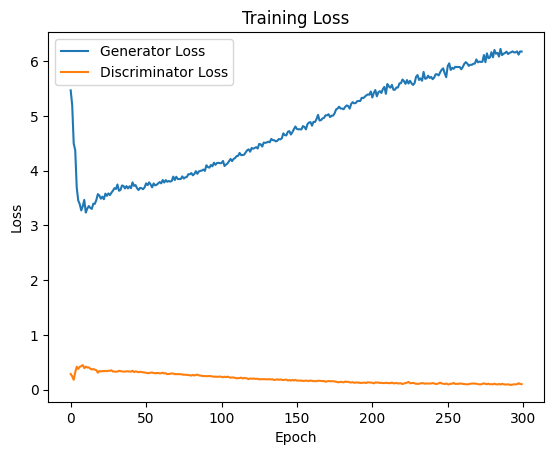

In [7]:
# Plot Losses
plt.plot(gen_losses, label='Generator Loss')
plt.plot(disc_losses, label='Discriminator Loss')
plt.legend()
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

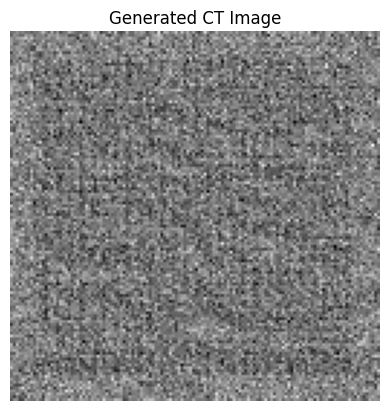

In [8]:
# Synthetic image generation after training

generator.eval()
synthetic_img = diffusion.sample(generator, device=device)

synthetic_img_np = synthetic_img.squeeze().cpu().numpy()
plt.imshow(synthetic_img_np, cmap='gray')
plt.title("Generated CT Image")
plt.axis("off")
plt.show()